In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import random_split, DataLoader, Dataset
from torchvision.utils import make_grid
from google.colab import drive

torch.manual_seed(777)
drive.mount('/content/drive')  

Mounted at /content/drive


In [2]:
if torch.cuda.is_available():
   device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)

cuda


In [3]:
class MyDataset(Dataset):
    def __init__(self, path):
        self.path = path
        handCheck = ['L', 'R']
        classes = os.listdir(self.path)
        cmap = {v:i for i, v in enumerate(classes)}
        self.x = []
        self.y = []
        for label in tqdm(classes):
            for handLabel in handCheck:
                for data in os.listdir(self.path+'/'+label+'/'+handLabel):
                    if data[0:5] != 'check':
                        self.x.append(self.path+'/'+label+'/'+handLabel+'/'+data)
                        self.y.append(cmap[label])
        del cmap, classes
    def __len__(self):
        return len(self.x)
        
    def __getitem__(self, idx):
        x = cv2.imread(self.x[idx])
        #x = cv2.resize(x, (448, 448))
        x = cv2.resize(x, (32, 32))         ## for test
        x = np.transpose(x, axes=(2, 0, 1))
        x = torch.from_numpy(x)/255
        y = self.y[idx]     # 0-39 -> (1-40)
        return x, y

In [4]:
dataPath = '/content/drive/MyDrive/hand_crop'       ## dataset이 저장되어 있는 폴더의 절대주소
dataList = os.listdir(dataPath)
print(dataList)

myData = MyDataset(dataPath)

['02', '01', '03', '04', '05', '06', '07', '08', '09', '10']


100%|██████████| 10/10 [05:15<00:00, 31.51s/it]


40695 34593 2034 4068
torch.Size([256, 3, 32, 32])
tensor([3, 3, 5, 3, 1, 3, 1, 4, 4, 6, 5, 5, 4, 5, 5, 5, 2, 1, 3, 5, 4, 5, 2, 1,
        4, 1, 3, 3, 2, 6, 4, 3, 2, 3, 1, 2, 5, 1, 2, 1, 2, 5, 1, 3, 4, 3, 5, 6,
        6, 4, 4, 4, 4, 1, 1, 6, 6, 2, 4, 2, 4, 4, 4, 5, 4, 2, 1, 3, 3, 3, 1, 5,
        5, 2, 5, 2, 5, 4, 4, 4, 3, 1, 4, 3, 6, 1, 4, 5, 1, 1, 4, 2, 1, 5, 1, 6,
        1, 3, 6, 4, 3, 5, 4, 4, 5, 1, 2, 1, 4, 4, 2, 3, 1, 6, 6, 5, 4, 3, 1, 2,
        5, 2, 4, 3, 4, 4, 2, 3, 1, 5, 4, 1, 1, 1, 2, 4, 3, 2, 1, 4, 1, 4, 5, 1,
        5, 1, 4, 1, 5, 4, 4, 4, 3, 2, 2, 3, 6, 2, 1, 2, 4, 4, 1, 3, 4, 3, 2, 1,
        3, 5, 6, 2, 5, 6, 3, 4, 3, 5, 5, 2, 2, 4, 4, 5, 5, 4, 1, 3, 1, 4, 6, 1,
        4, 1, 4, 6, 1, 3, 4, 6, 2, 6, 2, 2, 1, 2, 4, 1, 3, 3, 4, 3, 6, 3, 2, 3,
        3, 4, 3, 4, 5, 6, 1, 3, 4, 1, 5, 5, 1, 6, 4, 3, 4, 1, 4, 5, 1, 5, 3, 5,
        2, 4, 2, 2, 1, 1, 3, 1, 4, 5, 3, 4, 3, 4, 2, 2])


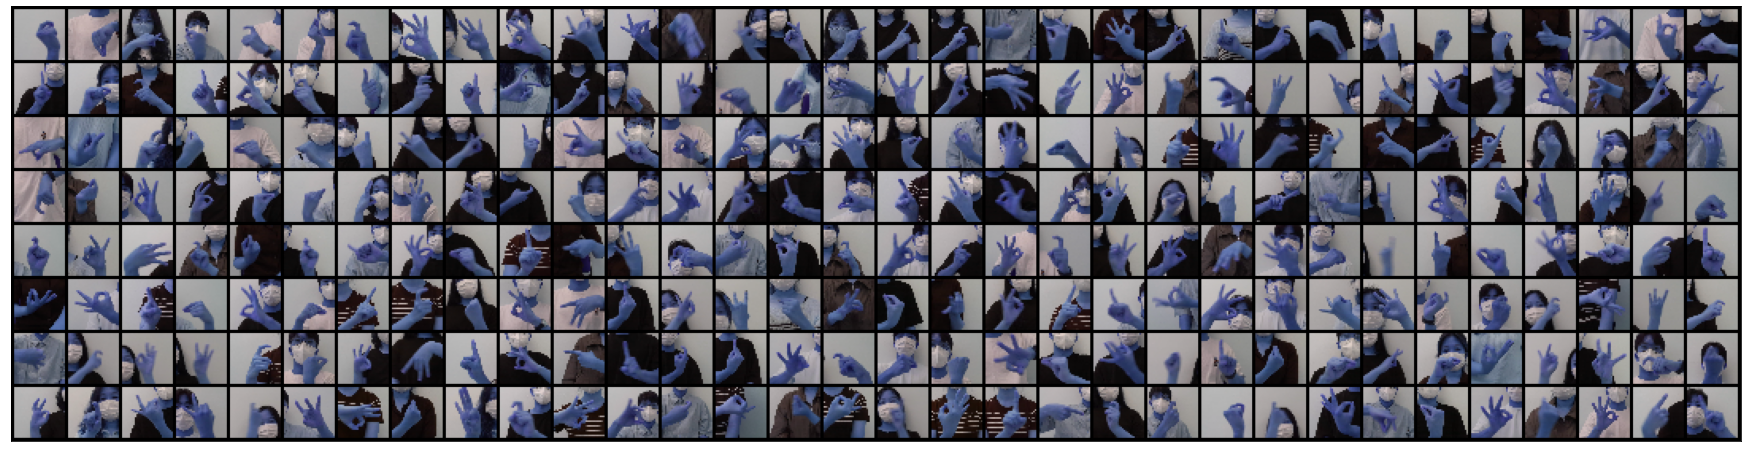

In [5]:
n = len(myData)
myData.__getitem__(0)
batchSize = 256*2
valSize = int(n*0.05)
testSize = 2*valSize
trainSize = n - (valSize + testSize)
print(n, trainSize, valSize, testSize)

train, val, test = random_split(myData, [trainSize, valSize, testSize])

trainDl = DataLoader(train, batchSize, num_workers=2, shuffle=True)
valDl = DataLoader(val, batchSize,shuffle=True)
testDl = DataLoader(test, batchSize)

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(32, 8))
        ax.set_xticks([]) ; ax.set_yticks([])
        print(images.shape)
        print(labels+1)
        ax.imshow(make_grid((images.to('cpu')), nrow=32).permute(1, 2, 0))
        break

show_batch(trainDl)

In [6]:
from locale import NOEXPR
## ResNet model
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def conv3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()

        ## 예외처리
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")

        ## 레이어 구성
        self.conv1 = conv3(inplanes, planes, stride)        ## 3x3 conv
        self.bn1 = norm_layer(planes)                       ## batch normalize
        self.relu = nn.ReLU(inplace=True)                   ## ReLu 활성화함수
        self.conv2 = conv3(planes, planes)                  ## 3x3 conv
        self.bn2 = norm_layer(planes)                       ## batch normalize
        self.downsample = downsample                        
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width/64.))*groups

        self.conv1 = conv1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ImageClassfication(nn.Module):
    def train_step(self, batch):
        images, classes = batch
        out = self(images)          #Generate prediction
        loss = F.cross_entropy(out, classes)   #Calculate loss
        return loss

    def validation_step(self, batch):
        images, classes = batch
        out = self(images)                  
        loss = F.cross_entropy(out, classes)
        acc = accuracy(out, classes)            #Calculate Accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses

        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies

        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

class ResNet(ImageClassfication):
    def __init__(self, block, layers, num_classes=40, zero_init_residual=False,
                 groups=1, width_per_group=64, norm_layer=None):
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        self.groups = groups
        self.base_width = width_per_group
        
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias = False)  ## 7x7 conv 224x224
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)                             ## 3x3 maxpool
        
        self.layer1 = self._make_layer(block ,64, layers[0])                                        ## 3x3 conv * 112x112
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)                             ## 3x3 conv * 56x56
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)                             ## 3x3 conv * 28x28
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)                             ## 3x3 conv * 14x14
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x
    
    def forward(self, x):
        return self._forward_impl(x)

In [8]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def training(epochs, lr, model, train_loader, val_loader,load=False,opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr, momentum=0.9)
    # if load:
    #     checkpoint = torch.load('./kinect.pth')
    #     model.load_state_dict(checkpoint['model_state_dict'])
    #     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    for epoch in range(epochs):
        #Training Phase
        model.train()
        train_losses = []
        count = 0
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            loss = model.train_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()

        #Validation Phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        # torch.save({
        #     'model_state_dict': model.state_dict(),
        #     'optimizer_state_dict': optimizer.state_dict()
        #     }, './kinect.pth')
    
    del loss, result, train_losses
    torch.cuda.empty_cache()
    return history

In [16]:
lr = 0.1 * (batchSize/256)
model = ResNet(Bottleneck, [3, 4, 6, 3], 40)    
## BasicBlock, [3, 4, 6, 3] ResNet-34
## Bottleneck, [3, 4, 6, 3] ResNet-50
## Bottleneck, [3, 4, 23, 3] ResNet-101
## Bottleneck, [3, 8, 36, 3] ResNet-152
## Bottleneck, [3, 4, 6, 3] ResnNext50_32x4d group = 32, width_per_group =4 
## Bottleneck, [3, 4, 23, 3] ResnNext101_32x8d group = 32, width_per_group = 8 
## Bottleneck, [3, 4, 6, 3] ResnNext50_2 width_per_group = 64*2
## Bottleneck, [3, 4, 23, 3] ResnNext101_2 width_per_group = 64*2



#print(model)

#test
# for images, classes in tqdm(trainDl):
#     out = model(images)
#     print(out)
#     print(out[0].sum())
#     break

In [ ]:
model.to(device)
epochs = 110
trainDl = DeviceDataLoader(trainDl, device)
valDl = DeviceDataLoader(valDl, device)
resNet_34_history = training(epochs, lr, model, trainDl, valDl)

 83%|████████▎ | 113/136 [01:36<00:21,  1.06it/s]